# Import Libraries

In [1]:
# Import library utama untuk analisis data dan visualisasi
import pandas as pd
import numpy as np # Make sure this line is executed
import matplotlib.pyplot as plt
import seaborn as sns

# Import library untuk Content-based Filtering
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

# Import library TensorFlow untuk deep learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, regularizers

# Import untuk preprocessing
from sklearn.preprocessing import LabelEncoder

# Import Path untuk memudahkan pengelolaan path file
from pathlib import Path

# Import untuk menampilkan tabel dengan format rapi
from tabulate import tabulate

# Data Understanding

In [2]:
# Upload file CSV
from google.colab import files
uploaded = files.upload()

Saving Ratings.csv to Ratings.csv
Saving Users.csv to Users.csv
Saving Books.csv to Books.csv


In [3]:
df_Ratings = pd.read_csv('Ratings.csv')
df_Users = pd.read_csv('Users.csv')
df_Books = pd.read_csv('Books.csv')

<ipython-input-3-65e9e184b78b>:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  df_Books = pd.read_csv('Books.csv')


## Rating

In [4]:
df_Ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1149780 entries, 0 to 1149779
Data columns (total 3 columns):
 #   Column       Non-Null Count    Dtype 
---  ------       --------------    ----- 
 0   User-ID      1149780 non-null  int64 
 1   ISBN         1149780 non-null  object
 2   Book-Rating  1149780 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 26.3+ MB


In [5]:
df_Ratings.head()

,User-ID,ISBN,Book-Rating
0,276725,034545104X,0
1,276726,0155061224,5
2,276727,0446520802,0
3,276729,052165615X,3
4,276729,0521795028,6


In [6]:
df_Ratings.groupby('Book-Rating').count()

,User-ID,ISBN
Book-Rating,,
0,716109,716109
1,1770,1770
2,2759,2759
3,5996,5996
4,8904,8904
5,50974,50974
6,36924,36924
7,76457,76457
8,103736,103736


In [7]:
df_Ratings['User-ID'].value_counts()

,count
User-ID,
11676,13602
198711,7550
153662,6109
98391,5891
35859,5850
...,...
119573,1
276706,1
276697,1


In [8]:
df_Ratings['ISBN'].value_counts()

,count
ISBN,
0971880107,2502
0316666343,1295
0385504209,883
0060928336,732
0312195516,723
...,...
0671883917,1
0743257502,1
0767409752,1


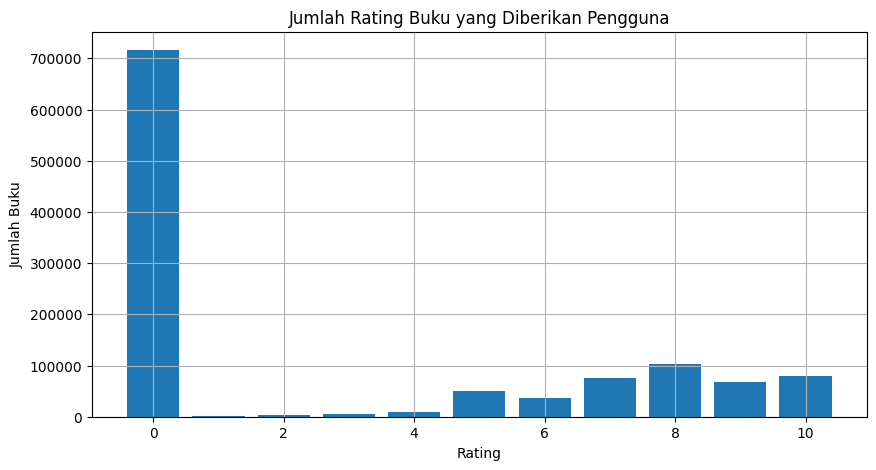

In [9]:
rating_counter = df_Ratings.groupby('Book-Rating').count()
plt.figure(figsize=(10,5))
plt.title('Jumlah Rating Buku yang Diberikan Pengguna')
plt.xlabel('Rating')
plt.ylabel('Jumlah Buku')
plt.bar(rating_counter.index, rating_counter['ISBN'])
plt.grid(True)
plt.show()

In [10]:
print(df_Ratings.isnull().sum())

User-ID        0
ISBN           0
Book-Rating    0
dtype: int64


## User

In [11]:
df_Users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 278858 entries, 0 to 278857
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   User-ID   278858 non-null  int64  
 1   Location  278858 non-null  object 
 2   Age       168096 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 6.4+ MB


In [12]:
df_Users.head()

,User-ID,Location,Age
0,1,"nyc, new york, usa",NaN
1,2,"stockton, california, usa",18.0
2,3,"moscow, yukon territory, russia",NaN
3,4,"porto, v.n.gaia, portugal",17.0
4,5,"farnborough, hants, united kingdom",NaN


In [13]:
print(df_Users.isnull().sum())

User-ID          0
Location         0
Age         110762
dtype: int64


<ipython-input-14-982aebfb28be>:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=avg_age_by_location.values, y=avg_age_by_location.index, palette='coolwarm')


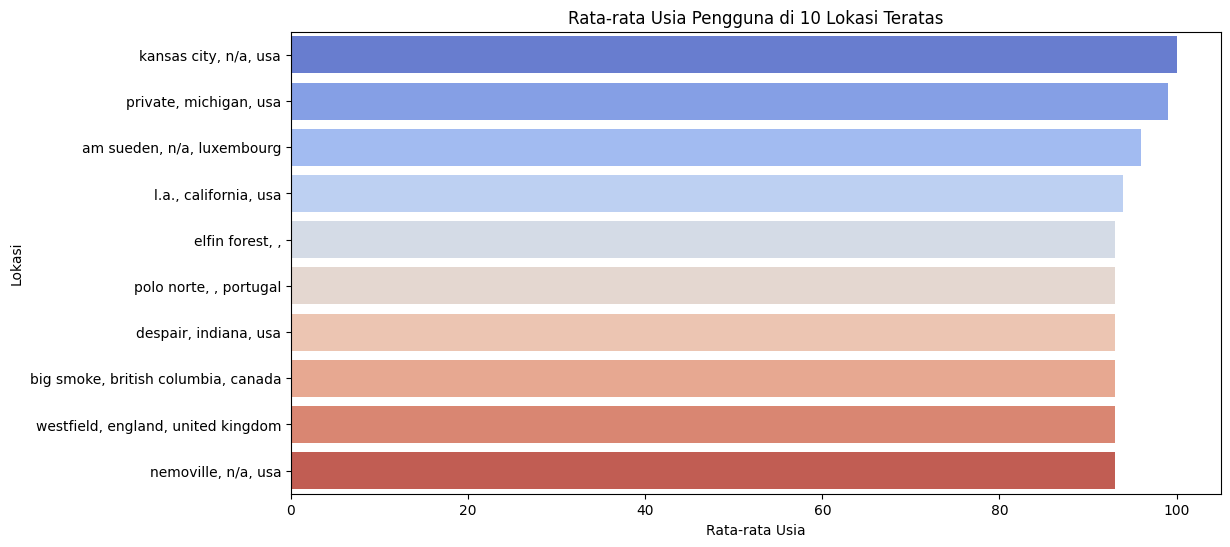

In [14]:
# Gabungkan data yang valid
valid_ages = df_Users[(df_Users['Age'] >= 5) & (df_Users['Age'] <= 100)]

# Hitung rata-rata umur per lokasi, lalu ambil 10 besar
avg_age_by_location = valid_ages.groupby('Location')['Age'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(12, 6))
sns.barplot(x=avg_age_by_location.values, y=avg_age_by_location.index, palette='coolwarm')
plt.title('Rata-rata Usia Pengguna di 10 Lokasi Teratas')
plt.xlabel('Rata-rata Usia')
plt.ylabel('Lokasi')
plt.show()


## Books

In [15]:
df_Books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271360 entries, 0 to 271359
Data columns (total 8 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   ISBN                 271360 non-null  object
 1   Book-Title           271360 non-null  object
 2   Book-Author          271358 non-null  object
 3   Year-Of-Publication  271360 non-null  object
 4   Publisher            271358 non-null  object
 5   Image-URL-S          271360 non-null  object
 6   Image-URL-M          271360 non-null  object
 7   Image-URL-L          271357 non-null  object
dtypes: object(8)
memory usage: 16.6+ MB


In [16]:
df_Books.head()

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...
2,0060973129,Decision in Normandy,Carlo D'Este,1991,HarperPerennial,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...,http://images.amazon.com/images/P/0060973129.0...
3,0374157065,Flu: The Story of the Great Influenza Pandemic...,Gina Bari Kolata,1999,Farrar Straus Giroux,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...,http://images.amazon.com/images/P/0374157065.0...
4,0393045218,The Mummies of Urumchi,E. J. W. Barber,1999,W. W. Norton &amp; Company,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...,http://images.amazon.com/images/P/0393045218.0...


In [17]:
print(df_Books.isnull().sum())

ISBN                   0
Book-Title             0
Book-Author            2
Year-Of-Publication    0
Publisher              2
Image-URL-S            0
Image-URL-M            0
Image-URL-L            3
dtype: int64


In [18]:
print('Banyak buku: ', len(df_Books.ISBN.unique()))

Banyak buku:  271360


In [19]:
df_Books['Book-Author'].value_counts()

,count
Book-Author,
Agatha Christie,632
William Shakespeare,567
Stephen King,524
Ann M. Martin,423
Carolyn Keene,373
...,...
JÃ¶rn Kalkbrenner,1
Paul A. Lynn,1
Arthur Bernard Williams,1


In [20]:
df_Books['Publisher'].value_counts()

,count
Publisher,
Harlequin,7535
Silhouette,4220
Pocket,3905
Ballantine Books,3783
Bantam Books,3646
...,...
Scholastic (An Apple Paperback),1
Spencer Butte Press,1
Kowalski,1


# Data Preprocessing

In [21]:
# Ambil ISBN unik dari kedua DataFrame lalu gabungkan dan urutkan
isbn_buku = df_Books['ISBN'].drop_duplicates()
isbn_rating = df_Ratings['ISBN'].drop_duplicates()
semua_isbn = np.unique(np.concatenate([isbn_buku, isbn_rating]))

# Tampilkan jumlah ISBN unik
print(f'Total ISBN unik dari semua data: {len(semua_isbn)}')


Total ISBN unik dari semua data: 341765


In [22]:
# Ekstraksi User-ID dari df_Ratings dan df_Users lalu gabungkan
user_dari_rating = df_Ratings['User-ID'].drop_duplicates()
user_dari_users = df_Users['User-ID'].drop_duplicates()
seluruh_user = np.unique(np.concatenate([user_dari_rating, user_dari_users]))

# Tampilkan jumlah total user unik
print(f'Total user unik: {len(seluruh_user)}')


Total user unik: 278858


In [23]:
# Lakukan merge antara df_Books dan df_Ratings berdasarkan ISBN
data_buku_rating = df_Books.merge(df_Ratings, on='ISBN', how='inner')

# Lihat hasil penggabungan awal
data_buku_rating.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0


In [24]:
# Gabungkan data buku-rating dengan df_Users berdasarkan User-ID
data_lengkap = data_buku_rating.merge(df_Users, on='User-ID', how='inner')

# Tampilkan beberapa baris data hasil akhir
data_lengkap.head()


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
1,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,8,5,"timmins, ontario, canada",NaN
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0,"ottawa, ontario, canada",49.0
3,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11676,8,"n/a, n/a, n/a",NaN
4,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,41385,0,"sudbury, ontario, canada",NaN


In [25]:
# Cek jumlah nilai kosong pada setiap kolom
data_lengkap.isna().sum()

,0
ISBN,0
Book-Title,0
Book-Author,2
Year-Of-Publication,0
Publisher,2
Image-URL-S,0
Image-URL-M,0
Image-URL-L,4
User-ID,0
Book-Rating,0


# Data Preparation

In [27]:
# Menghapus baris yang memiliki nilai NaN dari DataFrame 'data_lengkap'
clean_books = data_lengkap.dropna()
clean_books

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
0,0195153448,Classical Mythology,Mark P. O. Morford,2002,Oxford University Press,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,http://images.amazon.com/images/P/0195153448.0...,2,0,"stockton, california, usa",18.0
2,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,11400,0,"ottawa, ontario, canada",49.0
5,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,67544,8,"toronto, ontario, canada",30.0
6,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,85526,0,"victoria, british columbia, canada",36.0
7,0002005018,Clara Callan,Richard Bruce Wright,2001,HarperFlamingo Canada,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,http://images.amazon.com/images/P/0002005018.0...,96054,0,"ottawa, ontario, canada",29.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1031131,0440400988,There's a Bat in Bunk Five,Paula Danziger,1988,Random House Childrens Pub (Mm),http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,http://images.amazon.com/images/P/0440400988.0...,276463,7,"providence, rhode island, usa",26.0
1031132,0525447644,From One to One Hundred,Teri Sloat,1991,Dutton Books,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,http://images.amazon.com/images/P/0525447644.0...,276579,4,"orem, utah, usa",12.0
1031133,006008667X,Lily Dale : The True Story of the Town that Ta...,Christine Wicker,2004,HarperSanFrancisco,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,http://images.amazon.com/images/P/006008667X.0...,276680,0,"hopewell junction, new york, usa",55.0
1031134,0192126040,Republic (World's Classics),Plato,1996,Oxford University Press,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,http://images.amazon.com/images/P/0192126040.0...,276680,0,"hopewell junction, new york, usa",55.0


In [28]:
# Menampilkan jumlah missing value pada setiap kolom setelah pembersihan
clean_books.isna().sum()


,0
ISBN,0
Book-Title,0
Book-Author,0
Year-Of-Publication,0
Publisher,0
Image-URL-S,0
Image-URL-M,0
Image-URL-L,0
User-ID,0
Book-Rating,0


In [29]:
# Menyusun ulang data berdasarkan kolom ISBN dari A ke Z
sorted_books = clean_books.sort_values(by='ISBN', ascending=True)
sorted_books


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
1013651,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,171118,8,"toronto, ontario, canada",47.0
968139,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,209516,0,"felixstowe, suffolk, united kingdom",57.0
788100,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,196149,0,"lisburn, northern ireland, united kingdom",29.0
859117,0001046934,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,206300,0,"london, england, united kingdom",34.0
983063,0001047663,Matter Of Honour,Jeffrey Archer,2000,Trafalgar Square Books,http://images.amazon.com/images/P/0001047663.0...,http://images.amazon.com/images/P/0001047663.0...,http://images.amazon.com/images/P/0001047663.0...,246671,0,"melbourne, victoria, australia",27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
670608,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,264317,0,"portela de sacavém, loures, portugal",25.0
937591,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,100906,0,"seattle, washington, usa",34.0
828933,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,100088,0,"burnley, england, united kingdom",26.0
916406,B0002JV9PY,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,179791,0,"sydney, new south wales, australia",22.0


In [30]:
# Menyimpan ulang ke variabel baru dan mengurutkan lagi berdasarkan ISBN
prepared_books = sorted_books.copy()
prepared_books = prepared_books.sort_values(by='ISBN')
prepared_books


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
1013651,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,171118,8,"toronto, ontario, canada",47.0
968139,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,209516,0,"felixstowe, suffolk, united kingdom",57.0
788100,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,196149,0,"lisburn, northern ireland, united kingdom",29.0
859117,0001046934,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,206300,0,"london, england, united kingdom",34.0
983063,0001047663,Matter Of Honour,Jeffrey Archer,2000,Trafalgar Square Books,http://images.amazon.com/images/P/0001047663.0...,http://images.amazon.com/images/P/0001047663.0...,http://images.amazon.com/images/P/0001047663.0...,246671,0,"melbourne, victoria, australia",27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
670608,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,264317,0,"portela de sacavém, loures, portugal",25.0
937591,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,100906,0,"seattle, washington, usa",34.0
828933,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,100088,0,"burnley, england, united kingdom",26.0
916406,B0002JV9PY,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,179791,0,"sydney, new south wales, australia",22.0


In [31]:
# Menghapus entri duplikat berdasarkan ISBN
prepared_books = prepared_books.drop_duplicates(subset='ISBN')
prepared_books


,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
1013651,0000913154,The Way Things Work: An Illustrated Encycloped...,C. van Amerongen (translator),1967,Simon &amp; Schuster,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,http://images.amazon.com/images/P/0000913154.0...,171118,8,"toronto, ontario, canada",47.0
968139,0001010565,Mog's Christmas,Judith Kerr,1992,Collins,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,http://images.amazon.com/images/P/0001010565.0...,209516,0,"felixstowe, suffolk, united kingdom",57.0
788100,0001046713,Twopence to Cross the Mersey,Helen Forrester,1992,HarperCollins Publishers,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,http://images.amazon.com/images/P/0001046713.0...,196149,0,"lisburn, northern ireland, united kingdom",29.0
859117,0001046934,The Prime of Miss Jean Brodie,Muriel Spark,1999,Trafalgar Square Publishing,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,http://images.amazon.com/images/P/0001046934.0...,206300,0,"london, england, united kingdom",34.0
983063,0001047663,Matter Of Honour,Jeffrey Archer,2000,Trafalgar Square Books,http://images.amazon.com/images/P/0001047663.0...,http://images.amazon.com/images/P/0001047663.0...,http://images.amazon.com/images/P/0001047663.0...,246671,0,"melbourne, victoria, australia",27.0
...,...,...,...,...,...,...,...,...,...,...,...,...
670608,B000234N76,Falling Angels,Tracy Chevalier,2001,E P Dutton,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,http://images.amazon.com/images/P/B000234N76.0...,264317,0,"portela de sacavém, loures, portugal",25.0
937591,B000234NC6,It Must've Been Something I Ate: The Return of...,Jeffrey Steingarten,2002,Knopf,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,http://images.amazon.com/images/P/B000234NC6.0...,100906,0,"seattle, washington, usa",34.0
828933,B00029DGGO,"Good Wife Strikes Back, The",Elizabeth Buchan,0,Viking Adult,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,http://images.amazon.com/images/P/B00029DGGO.0...,100088,0,"burnley, england, united kingdom",26.0
916406,B0002JV9PY,The Blockade Runners,Jules Verne,0,Digireads.com,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,http://images.amazon.com/images/P/B0002JV9PY.0...,179791,0,"sydney, new south wales, australia",22.0


In [41]:
# Ambil sampel acak dari data
sample_books = prepared_books.sample(n=10000, random_state=42)

# Filter data: hanya yang memiliki rating lebih dari 0
books_rating_clean = sample_books[sample_books['Book-Rating'] > 0]

# Lanjutkan proses, misalnya tampilkan beberapa data
# Display the DataFrame
display(books_rating_clean)

,ISBN,Book-Title,Book-Author,Year-Of-Publication,Publisher,Image-URL-S,Image-URL-M,Image-URL-L,User-ID,Book-Rating,Location,Age
796725,8435006484,El Salon Dorado (Narrativas Historicas Edhasa),Jose Luis Corral Lafuente,1999,Edhasa,http://images.amazon.com/images/P/8435006484.0...,http://images.amazon.com/images/P/8435006484.0...,http://images.amazon.com/images/P/8435006484.0...,87482,8,"barcelona, catalunya, spain",36.0
325161,0756400007,Flightless Falcon,Mickey Zucker Reichert,2001,Daw Books,http://images.amazon.com/images/P/0756400007.0...,http://images.amazon.com/images/P/0756400007.0...,http://images.amazon.com/images/P/0756400007.0...,13607,8,"clayton, north carolina, usa",31.0
396036,0345434137,Chicks Rule: The Story of the Dixie Chicks,Scott Gray,1999,Ballantine Books,http://images.amazon.com/images/P/0345434137.0...,http://images.amazon.com/images/P/0345434137.0...,http://images.amazon.com/images/P/0345434137.0...,8067,8,"owings mills, maryland, usa",26.0
824464,0345428927,Heart and Soul,SALLY MANDEL,2002,Ballantine Books,http://images.amazon.com/images/P/0345428927.0...,http://images.amazon.com/images/P/0345428927.0...,http://images.amazon.com/images/P/0345428927.0...,98391,9,"morrow, georgia, usa",52.0
857508,8437602793,Altazor Temblor De Cielo (Letras Hispanicas),Vicente Huidobro,1994,Ediciones Catedra S.A.,http://images.amazon.com/images/P/8437602793.0...,http://images.amazon.com/images/P/8437602793.0...,http://images.amazon.com/images/P/8437602793.0...,68688,7,"lisbon, lisbon, portugal",26.0
...,...,...,...,...,...,...,...,...,...,...,...,...
977627,3426616688,Die MondsteinmÃ?Â¤rchen. Ein MÃ?Â¤rchenbuch ni...,Roland KÃ?Â¼bler,2000,"Droemersche Verlagsanstalt Th. Knaur Nachf., G...",http://images.amazon.com/images/P/3426616688.0...,http://images.amazon.com/images/P/3426616688.0...,http://images.amazon.com/images/P/3426616688.0...,258175,10,"siegen, nordrhein-westfalen, germany",21.0
826035,0060199644,Listen to the Shadows: A Novel,Danuta Reah,2001,William Morrow &amp; Company,http://images.amazon.com/images/P/0060199644.0...,http://images.amazon.com/images/P/0060199644.0...,http://images.amazon.com/images/P/0060199644.0...,98391,10,"morrow, georgia, usa",52.0
743874,8474861004,El Guardamarina Bolitho,Alexander Kent,1998,Noray,http://images.amazon.com/images/P/8474861004.0...,http://images.amazon.com/images/P/8474861004.0...,http://images.amazon.com/images/P/8474861004.0...,49144,5,"ferreries, illes balears, spain",43.0
972936,0373632029,Renegade War (Survival 2000 #2) (Survival 200...,James McPhee,1991,Gold Eagle,http://images.amazon.com/images/P/0373632029.0...,http://images.amazon.com/images/P/0373632029.0...,http://images.amazon.com/images/P/0373632029.0...,254543,8,"fresno, california, usa",57.0


In [42]:
# Mengubah tiga kolom menjadi list untuk digunakan dalam pemodelan
list_ids = sample_books['ISBN'].to_list()
list_titles = sample_books['Book-Title'].to_list()
list_authors = sample_books['Book-Author'].to_list()

print(f"Jumlah ID: {len(list_ids)}")
print(f"Jumlah Judul: {len(list_titles)}")
print(f"Jumlah Penulis: {len(list_authors)}")


Jumlah ID: 10000
Jumlah Judul: 10000
Jumlah Penulis: 10000


In [43]:
# Menyusun DataFrame baru dengan struktur yang dibutuhkan
books_final = pd.DataFrame({
    'id': list_ids,
    'book_title': list_titles,
    'book_author': list_authors
})
books_final


,id,book_title,book_author
0,8435006484,El Salon Dorado (Narrativas Historicas Edhasa),Jose Luis Corral Lafuente
1,0756400007,Flightless Falcon,Mickey Zucker Reichert
2,0345434137,Chicks Rule: The Story of the Dixie Chicks,Scott Gray
3,0773673881,Maria Chapdelaine,Louis Hemon
4,0345428927,Heart and Soul,SALLY MANDEL
...,...,...,...
9995,0373513232,A Perfect Cover (Bombshell),Maureen Tan
9996,078681716X,Spy Kids Adventures: A New Kind of Super Spy,Elizabeth Lenhard
9997,0373116411,"Threat From The Past (Harlequin Presents, No 1...",Tisha Hamilton
9998,0373105797,Golden Fever (Harlequin Presents),Carole Mortimer


# Model Development dengan Content Based Filtering

In [46]:
# Menyalin dataset akhir ke variabel baru
dataset = books_final.copy()

# Menampilkan 5 baris acak dari dataset
dataset.sample(n=5)


,id,book_title,book_author
2329,0582292190,The Media and Mental Distress,Glasgow Media Group
6394,2876786710,Le Livre d'un homme seul,Gao Xingjian
9254,0946819831,Woodturning Jewelry,Hilary Bowen
3892,0440947359,Love and Betrayal and Hold the Mayo!,Francine Pascal
6660,8484504336,Antologias de Las Mejores Poesias,Luis Maria Anson


In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Membuat instance dari TfidfVectorizer
vectorizer = TfidfVectorizer()

# Melatih vectorizer menggunakan data penulis buku
vectorizer.fit(dataset['book_author'])

# Menampilkan semua fitur (kata unik)
vectorizer.get_feature_names_out()


array(['aaaaaa', 'aaron', 'abagnale', ..., 'â¼ller', 'â¼nter', 'â¼rgen'],
      dtype=object)

In [48]:
# Mengubah data penulis menjadi representasi vektor TF-IDF
tfidf_result = vectorizer.fit_transform(dataset['book_author'])

# Menampilkan dimensi dari hasil transformasi
tfidf_result.shape


(10000, 7382)

In [49]:
# Mengubah sparse matrix menjadi bentuk dense (matriks penuh)
tfidf_dense = tfidf_result.todense()
tfidf_dense


matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [50]:
# Mengonversi matrix ke DataFrame untuk visualisasi
tfidf_df = pd.DataFrame(
    tfidf_dense,
    columns=vectorizer.get_feature_names_out(),
    index=dataset['book_title']
)

# Menampilkan 10 baris dan 22 kolom secara acak
tfidf_df.sample(n=10).sample(n=22, axis=1)

,lowther,druse,forman,gwynne,edghill,angel,westwood,flint,byars,reavis,...,zillah,silberg,gowdy,auerbach,mowat,luigi,bates,weldon,beth,carola
book_title,,,,,,,,,,,,,,,,,,,,,
Southern Daughter: The Life of Margaret Mitchell,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
U2: A Conspiracy of Hope,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Truth or Dare,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Complete Peanuts 1950-1952,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Misadventures of Maria O'Mara,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"A Horse for Mary Beth (Riding Academy, No 1)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Sap Rising,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Needlecraft treasury,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Das dritte Buch Ã?Â¼ber Achim. Roman.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
from sklearn.metrics.pairwise import cosine_similarity

# Menghitung cosine similarity antara semua buku
similarity_scores = cosine_similarity(tfidf_result)
similarity_scores


array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [52]:
# Membentuk dataframe similarity dengan label judul buku
similarity_df = pd.DataFrame(similarity_scores, index=dataset['book_title'], columns=dataset['book_title'])

# Menampilkan ukuran matriks
print("Dimensi matriks:", similarity_df.shape)

# Menampilkan sebagian data
similarity_df.sample(n=10).sample(n=5, axis=1)


Dimensi matriks: (10000, 10000)


book_title,In the Forest of the Night,Spawn of Dykes to Watch Out for (Dykes to Watch Out for),A Coffin for Dimitrios (Vintage Crime/Black Lizard),Madonna: Blonde Ambition,Oz #04 Dorothy and Wizard of Oz
book_title,,,,,
Pursuing The Will of God,0.0,0.0,0.0,0.0,0.0
Outerbridge Reach,0.0,0.0,0.0,0.0,0.0
The Ghost in the Big Brass Bed,0.0,0.0,0.0,0.0,0.0
The Gauntlet (Oxford Children's Modern Classics),0.0,0.0,0.0,0.0,0.0
Miss Bugle Saw God in the Cabbages,0.0,0.0,0.0,0.0,0.0
Letter to Lord Liszt,0.0,0.0,0.0,0.0,0.0
Hanging Curve,0.0,0.0,0.0,0.0,0.0
"Never Tease a Wolf (Silhouette Desire, No. 652)",0.0,0.0,0.0,0.0,0.0
"Besieged (Harlequin Presents, 1498)",0.0,0.0,0.0,0.0,0.0


In [53]:
def rekomendasi_buku(judul, similarity_data=similarity_df, metadata=dataset[['book_title', 'book_author']], jumlah=5):
    """
    Menghasilkan daftar buku yang mirip berdasarkan judul input.
    """
    # Menemukan indeks kemiripan tertinggi (k+1 karena termasuk dirinya sendiri)
    indeks_terdekat = similarity_data.loc[:, judul].to_numpy().argpartition(range(-1, -jumlah, -1))

    # Ambil nama-nama judul teratas
    rekomendasi = similarity_data.columns[indeks_terdekat[-1:-(jumlah+2):-1]]

    # Menghapus buku input dari hasil rekomendasi
    rekomendasi = rekomendasi.drop(judul, errors='ignore')

    return pd.DataFrame(rekomendasi).merge(metadata).head(jumlah)


In [54]:
# Menampilkan data buku berdasarkan judul tertentu
dataset[dataset['book_title'] == 'Letter to Lord Liszt']


,id,book_title,book_author
2772,0030710278,Letter to Lord Liszt,Martin Walser


In [55]:
# Menampilkan rekomendasi untuk judul yang diberikan
rekomendasi_buku('Letter to Lord Liszt')

,book_title,book_author
0,Das Einhorn,M. Walser
1,Computer Data-Base Organization (Prentice-Hall...,James Martin
2,Cul-De-Sac,David Martin
3,Die PulververschwÃ?Â¶rung.,Martin Stephen
4,Stacey's Book (The Baby-Sitters Club Portrait ...,Ann M. Martin


In [56]:
# Menetapkan nilai ambang batas untuk kemiripan
nilai_ambang = 0.5

# Membuat matriks ground truth biner
truth_matrix = (similarity_scores >= nilai_ambang).astype(int)

# Mengambil sebagian data untuk visualisasi
pd.DataFrame(truth_matrix, index=dataset['book_title'], columns=dataset['book_title']).sample(10).sample(5, axis=1)


book_title,Ta Today: A New Introduction to Transactional Analysis,Harriet and the Robot,Das GlÃ¼cksrad: Geschichten zum Jahreslauf,Bangalee,Jason and the Baseball Bear
book_title,,,,,
Dream Brother: The Lives and Music of Jeff and Tim Buckley,0,0,0,0,0
"Halloween Honeymoon (Silhouette Desire, No. 1030)",0,0,0,0,0
"With A Little Luck #49 (Janet Dailey Americana, No. 49)",0,0,0,0,0
Chasing the Dime,0,0,0,0,0
"Hanging Baskets, Window Boxes, And Other Container Gardens : A Guide To Creative Small-Scale Gardening",0,0,0,0,0
Handbuch der Malerei und Kalligraphie.,0,0,0,0,0
Escape from Blood Castle (Usborne Puzzle Adventures),0,0,0,0,0
Entertaining an Elephant: A Novel about Learning &amp; Letting Go,0,0,0,0,0
North Dallas After Forty,0,0,0,0,0


In [57]:
# Menentukan jumlah sampel evaluasi
ukuran_sampel = 10000

# Membuat subset dari similarity dan ground truth
sim_sampel = similarity_scores[:ukuran_sampel, :ukuran_sampel]
truth_sampel = truth_matrix[:ukuran_sampel, :ukuran_sampel]

# Ubah ke bentuk satu dimensi
sim_flat = sim_sampel.flatten()
truth_flat = truth_sampel.flatten()


In [59]:
# Buat prediksi dari cosine similarity dengan threshold
prediksi = (sim_flat >= nilai_ambang).astype(int)

# Evaluasi prediksi
precision, recall, f1, _ = precision_recall_fscore_support(
    truth_flat, prediksi, average='binary', zero_division=1
)

# Menampilkan hasil evaluasi
print(f"Precision : {precision:.2f}")
print(f"Recall    : {recall:.2f}")
print(f"F1-score  : {f1:.2f}")


Precision : 1.00
Recall    : 1.00
F1-score  : 1.00


Collaborative Filtering

In [65]:
# Memilih kolom yang dibutuhkan dari dataset
selected_cols = ['User-ID', 'ISBN', 'Book-Rating']
ratings_df = books_rating_clean[selected_cols]
ratings_df.head()

,User-ID,ISBN,Book-Rating
796725,87482,8435006484,8
325161,13607,0756400007,8
396036,8067,0345434137,8
824464,98391,0345428927,9
857508,68688,8437602793,7


In [66]:
# Mendapatkan daftar user unik
unique_users = ratings_df['User-ID'].drop_duplicates().tolist()

# Mapping dari User-ID ke indeks numerik
user_id_to_index = {user_id: idx for idx, user_id in enumerate(unique_users)}

# Mapping balik dari indeks ke User-ID
index_to_user_id = {idx: user_id for user_id, idx in user_id_to_index.items()}


In [67]:
# Mendapatkan ISBN unik dari data
unique_books = ratings_df['ISBN'].unique().tolist()

# Mapping ISBN ke index numerik
isbn_to_index = {isbn: idx for idx, isbn in enumerate(unique_books)}

# Mapping balik dari index ke ISBN
index_to_isbn = {idx: isbn for isbn, idx in isbn_to_index.items()}


In [68]:
# Tambahkan kolom hasil encoding ke dataframe
ratings_df['user_index'] = ratings_df['User-ID'].map(user_id_to_index)
ratings_df['book_index'] = ratings_df['ISBN'].map(isbn_to_index)

<ipython-input-68-00a0f2c39f65>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['user_index'] = ratings_df['User-ID'].map(user_id_to_index)
<ipython-input-68-00a0f2c39f65>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['book_index'] = ratings_df['ISBN'].map(isbn_to_index)


In [69]:
# Hitung total user dan total buku yang unik
total_users = len(user_id_to_index)
total_books = len(isbn_to_index)

print("Total users:", total_users)
print("Total books:", total_books)


Total users: 2304
Total books: 3609


In [70]:
# Mengubah rating ke float32
ratings_df['score'] = ratings_df['Book-Rating'].astype(np.float32)

# Mendapatkan rating minimum dan maksimum
min_score = ratings_df['score'].min()
max_score = ratings_df['score'].max()

print(f"Users: {total_users}, Books: {total_books}, Min Rating: {min_score}, Max Rating: {max_score}")


Users: 2304, Books: 3609, Min Rating: 1.0, Max Rating: 10.0


<ipython-input-70-7d5e2effa79f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ratings_df['score'] = ratings_df['Book-Rating'].astype(np.float32)


In [73]:
# Ambil 10.000 sample secara acak untuk efisiensi training
# Check if the number of rows is less than the desired sample size
if ratings_df.shape[0] < 10000:
    # Use the entire DataFrame if it's smaller than 10000
    ratings_df = ratings_df
else:
    # Sample 10000 rows if the DataFrame is large enough
    ratings_df = ratings_df.sample(n=10000, random_state=42)

ratings_df.head()

,User-ID,ISBN,Book-Rating,user_index,book_index,score
796725,87482,8435006484,8,0,0,8.0
325161,13607,0756400007,8,1,1,8.0
396036,8067,0345434137,8,2,2,8.0
824464,98391,0345428927,9,3,3,9.0
857508,68688,8437602793,7,4,4,7.0


In [74]:
# Membuat fitur (user dan buku) dan label (rating dinormalisasi)
features = ratings_df[['user_index', 'book_index']].to_numpy()
labels = ratings_df['score'].apply(lambda s: (s - min_score) / (max_score - min_score)).to_numpy()

# Split data menjadi 80% training dan 20% validasi
train_split = int(0.8 * len(features))
x_train, x_val = features[:train_split], features[train_split:]
y_train, y_val = labels[:train_split], labels[train_split:]


In [76]:
# Mengubah data teks author menjadi matriks TF-IDF
tfidf_result = vectorizer.transform(data['book_author'])

# Buat dataframe untuk menampilkan hasil TF-IDF
tfidf_df = pd.DataFrame(
    tfidf_result.todense(),
    columns=vectorizer.get_feature_names_out(),
    index=data['book_title']
)

# Tampilkan sebagian kecil hasil untuk contoh
tfidf_df.sample(10, axis=0).sample(22, axis=1)


,fischer,skutch,mangum,obeyesekere,spielvogel,chefs,julius,georgette,messing,addams,...,stanislas,gaius,sutherland,kicklighter,byars,gripe,caledonia,susie,herron,appleby
book_title,,,,,,,,,,,,,,,,,,,,,
I Believe in You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Face On the Milk Carton,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Summer People-Open Mkt,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The End of the Pier,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Das schwarze Reich. Geheimgesellschaften und Politik im 20. Jahrhundert.,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Season in Eden,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A Month in the Country,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
The Ivory and the Horn: A Newford Collection,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Boris aprÃ?Â¨s l'amour,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [78]:
# Definisikan arsitektur model rekomendasi
class BookRecommender(Model):
    def __init__(self, user_count, book_count, emb_dim):
        super().__init__()
        # Layer embedding untuk user dan buku
        self.user_emb = layers.Embedding(user_count, emb_dim, embeddings_initializer='he_normal',
                                         embeddings_regularizer=regularizers.l2(1e-6))
        self.user_bias = layers.Embedding(user_count, 1)
        self.book_emb = layers.Embedding(book_count, emb_dim, embeddings_initializer='he_normal',
                                         embeddings_regularizer=regularizers.l2(1e-6))
        self.book_bias = layers.Embedding(book_count, 1)

    def call(self, inputs):
        # Hitung dot product + bias
        u_vec = self.user_emb(inputs[:, 0])
        b_vec = self.book_emb(inputs[:, 1])
        u_bias = self.user_bias(inputs[:, 0])
        b_bias = self.book_bias(inputs[:, 1])
        dot = tf.reduce_sum(u_vec * b_vec, axis=1, keepdims=True)
        return tf.nn.sigmoid(dot + u_bias + b_bias)


In [79]:
# Inisialisasi dan compile model
model = BookRecommender(total_users, total_books, 50)
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

# Training model
training_history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=12,
    epochs=25,
    validation_data=(x_val, y_val)
)


Epoch 1/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 10s 16ms/step - loss: 0.6923 - root_mean_squared_error: 0.3187 - val_loss: 0.6884 - val_root_mean_squared_error: 0.3227
Epoch 2/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.6797 - root_mean_squared_error: 0.3087 - val_loss: 0.6842 - val_root_mean_squared_error: 0.3194
Epoch 3/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 17ms/step - loss: 0.6579 - root_mean_squared_error: 0.2939 - val_loss: 0.6808 - val_root_mean_squared_error: 0.3165
Epoch 4/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - loss: 0.6282 - root_mean_squared_error: 0.2694 - val_loss: 0.6783 - val_root_mean_squared_error: 0.3143
Epoch 5/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 0.5948 - root_mean_squared_error: 0.2350 - val_loss: 0.6767 - val_root_mean_squared_error: 0.3126
Epoch 6/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - loss: 0.5622 - root_mean_squared_error: 0.2025 - val_loss: 0.6758 - val_root_mean_squared_error: 0.3114
Epoch 7/25
241/241 ━━━━━━━━━━━━━━━━━━━━ 5s 20m

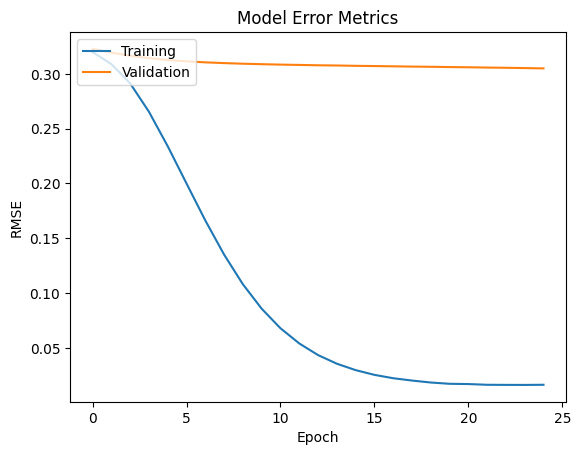

In [80]:
# Menampilkan grafik RMSE untuk train dan validation
plt.plot(training_history.history['root_mean_squared_error'])
plt.plot(training_history.history['val_root_mean_squared_error'])
plt.title('Model Error Metrics')
plt.ylabel('RMSE')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()


In [82]:
# Ambil 1 sample user dari dataset
user_sample = ratings_df['User-ID'].sample(1).iloc[0]

# Cari buku yang sudah dibaca user
visited_books = ratings_df[ratings_df['User-ID'] == user_sample]

# Cari buku yang belum dibaca user
# Menggunakan 'books_final' yang berisi informasi buku
book_candidates = books_final[~books_final['id'].isin(visited_books['ISBN'])]
book_candidates = book_candidates[book_candidates['id'].isin(isbn_to_index)]

# Siapkan input prediksi untuk user tersebut
book_indices = [[isbn_to_index[isbn]] for isbn in book_candidates['id']]
user_idx = user_id_to_index[user_sample]
input_array = np.hstack((np.full((len(book_indices), 1), user_idx), book_indices))

In [84]:
# Prediksi skor rekomendasi
predicted_scores = model.predict(input_array).flatten()
top_indices = predicted_scores.argsort()[-10:][::-1]

# Ambil ISBN dari 10 prediksi terbaik
recommended_isbns = [index_to_isbn[book_indices[i][0]] for i in top_indices]

# Tampilkan hasil
print(f"Rekomendasi untuk user: {user_sample}")
print("===" * 10)

# Buku dengan rating tertinggi yang sudah dibaca user
top_user_books = visited_books.sort_values(by='score', ascending=False).head(5)['ISBN']
# Mengganti books_new dengan books_final yang sudah didefinisikan
for book in books_final[books_final['id'].isin(top_user_books)].itertuples():
    print(f"{book.book_title} oleh {book.book_author}")

print("---" * 10)
print("Top 10 Rekomendasi:")
# Mengganti books_new dengan books_final yang sudah didefinisikan
for book in books_final[books_final['id'].isin(recommended_isbns)].itertuples():
    print(f"{book.book_title} oleh {book.book_author}")

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Rekomendasi untuk user: 32188
The Partner oleh John Grisham
------------------------------
Top 10 Rekomendasi:
The Christmas Treasury oleh Ideals Publications Inc
The Adventures of Huckleberry Finn oleh Mark Twain
The Wisdom of John Paul II: The Pope on Life's Most Vital Questions (Vintage Spiritual Classics) oleh John Paul
Kaplan Learning Power (Kaplan Power Books) oleh Cynthia Johnson
Inside Avatar The Book: Achieving Enlightenment oleh Harry Palmer
Jizo Bodhisattva: Modern Healing and Traditional Buddhist Practice oleh Jan Chozen Bays
Joy of Cooking oleh Irma S. Rombauer
A World of Baby Names oleh Teresa Norman
Labrador Retrievers: Everything About Purchase, Care, Nutrition, Diseases, Breeding, and Behavior (Barron's Complete Pet Owner's Manuals) oleh Kerry V. Kern
The New French Baker: Perfect Pastries and Beautiful Breads from Your Kitchen oleh Sheila Linderman
